# Chapter 12 - Long/Short Portfolio Management #
&copy; 2021 Kenneth Winston

Until now we have mainly focused on positive assets: you can't lose more than you invest by buying a stock or a bond. The shield of bankruptcy protects stockholders: a company that goes bankrupt with more liabilities than assets cannot force stockholders to make up the difference. Similarly bond indenture agreements insure that the worst thing that can happen to a bondholder is the loss of principal and interest payments owed by the bond issuer.

We have discussed short selling, both implicit and explicit. Explicit short selling occurs when an investor takes a negative position in a positive asset. One way to express pessimism about (say) Tesla is to borrow shares of Tesla from someone who owns those shares and sell the borrowed shares for cash. The borrower now has positive cash and a negative position in Tesla, which is owed to the lender. At some later time, the borrower closes out the position by buying Tesla in the open market and returning the shares to the lender. If the pessimistic borrower was right, the later repurchase in the open market will be at a lower price than the sale at the time of borrowing.

Because this transaction doesn't require investment on the part of the short seller, it can immediately have a negative value if Tesla goes up in price. Similarly writing (selling) an option can have negative value as soon as the option premium collected at initiation of the write is less than the current value of the option. Other instruments with implicit short sides &mdash; forwards, futures, interest rate and credit default swaps &mdash; can also go negative in value.

The presence of a minus sign wreaks havoc on the assumption of a lognormal distribution of prices with domain $[0,\infty]$. Nor does it suffice to replace lognormal with normal. A distribution which is the difference between two roughly lognormal-shaped distributions (positive assets long minus positive assets short) has its own characteristics. This is particularly apparent when considering hedge funds. In this chapter we'll explore the implications for managing long/short (hedge) portfolios.[$^1$](#twelve_footnotes)

## 12.1 Basic long/short model ##

We'll start by reviewing the nature of the lognormal model, which is essentially a model of exponential growth. We showed the basic diffusion process in Chapter 3:
$$dx=\alpha (t,x)dt + \sigma (t,x)d\beta\label{eq:sde_diffusion_function}\tag{3.21}$$

We've seen that using It&ocirc;’s lemma (3.24)\eqref{itos_lemma} with \eqref{eq:sde_diffusion_function} and $\alpha(t,x)=\alpha x$; $\sigma(t,x)=\sigma x$ (where the RHS $\alpha$ and $\sigma$ are constants) transforms $f(x)=ln(x)$ to
$$d(ln(x))=(\alpha-\sigma^2/2)dt+\sigma d\beta\label{eq:lognormal_process}\tag{12.1}$$
This is also called **`geometric Brownian motion`** or GBM.

\eqref{eq:lognormal_process} is an easy differential equation with solution
$$X(T)=\color{green}{X(0)exp((\alpha-\sigma^2/2)T)}\color{red}{exp(\sigma\beta(T))}
\label{eq:lognormal_solution}\tag{12.2}$$

The <span style="color:green">green part</span> of \eqref{eq:lognormal_solution} is a straightforward exponential. We would get that if there was no stochastic component to \eqref{eq:lognormal_process}. The stochastic component brings in the <span style="color:red">random walk in red.</span>

Figures 12.1 and 12.2 show the two components separately. $\gamma=\alpha-\sigma^2/2$ is the geometric growth rate:

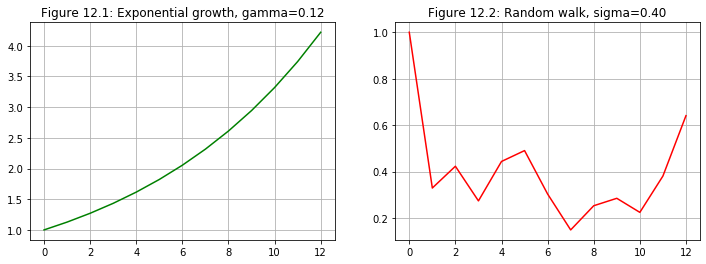

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

alpha=.2
sigma=.4
periods=12
gamma=alpha-sigma**2/2
plt.figure(figsize=(12,4))   #Do side-by-side graphs
times=np.arange(0,periods+1)

#Exponential growth graph
expo=np.exp(gamma*(times))

plt.subplot(1,2,1)
plt.plot(times,expo,color="g")
plt.grid()
str_title="Figure 12.1: Exponential growth, gamma=%3.2f" % gamma
plt.title(str_title)

#Random walk graph
np.random.seed(662607)
norm_cum=np.cumsum(np.random.normal(size=periods+1))
#zero period is present - no movement
norm_cum[0]=0
rand_walk=np.exp(sigma*norm_cum)

plt.subplot(1,2,2)
plt.plot(times,rand_walk,color="r")
plt.grid()
str_title="Figure 12.2: Random walk, sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

In a Monte Carlo simulation (Chapter 7), we just run the right graph multiple times and add it to the left graph. In Figure 12.3 the y axis scale is logarithmic to better separate outcomes. The straight (on a log scale) green line is nonstochastic growth.

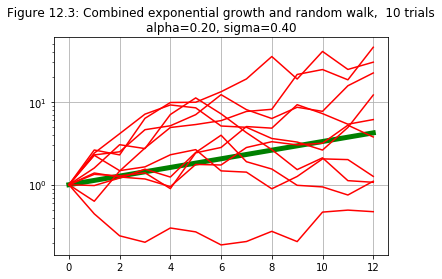

In [189]:
#Graph multiple combined exponential/random walks

#Plot the nonstochastic exponential growth
plt.plot(times,expo,color="g",linewidth=5)

num_trials=10
for trial in range(num_trials):
    norm_cum=np.cumsum(np.random.normal(size=periods+1))
    #zero period is present - no movement
    norm_cum[0]=0
    rand_walk=expo*np.exp(sigma*norm_cum)

    plt.plot(times,rand_walk,color="r")

plt.yscale('log')
plt.grid()
str_title="Figure 12.3: Combined exponential growth and random walk, %3.f" \
    % num_trials
str_title+=" trials\nalpha=%3.2f" % alpha
str_title+=", sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

As noted in the introduction to this chapter, the value never goes negative because of the exp's in \eqref{eq:lognormal_solution}. That's the desired behavior for positive assets.

But hedge funds and other arrangements where there is both a long and a short side are not positive assets. In general we can write a long/short portfolio or instrument as a set of positive assets (the longs) worth $L(T)$ at time $T$, and another set of positive assets (the shorts) worth $S(T)$ at time $T$, but held negatively so that the overall portfolio is worth $L(T)-S(T)$ at time $T$.

A long/short manager seeks longs such that $L(T)\to\infty$ and shorts such that $S(T)\to0$ as $T$ increases: i.e. good longs and bad shorts. Since each side is a positive asset, we can model the portfolio as two possibly correlated GBM's:
$$\frac{dL}{L}=\alpha_Ldt+\sigma_LdZ_L;\quad\frac{dS}{S}=\alpha_Sdt+\sigma_SdZ_S$$
$$dZ_ldZ_S=\rho dt\label{eq:dual_GBM}\tag{12.3}$$

A linear combination of GBM's $L(T)-S(T)$ is NOT a GBM. In fact this linear combination is not anything that can be written in closed form. Eventually the Central Limit Theorem would kick in if we had a large number of GBM's, but $2<<\infty$.

Importantly, the long/short portfolio can have $L(T)<S(T)$ and thus take on a negative value. This is frowned upon in investing circles: to establish a negative position, the long/short investor essentially borrowed money. If $L(T)<S(T)$, the portfolio cannot pay back the lender and will default.

Default can be surprisingly unfatal. Consider the case of John Meriwether[$^2$](#twelve_footnotes), founder of the LTCM hedge fund we saw in section 4.1.1:
>John Meriwether was in charge of fixed-income trading at Salomon at the time of a bond-trading scandal in 1991, in which traders under Meriwether made false bids in an effort to manipulate the market in two-year notes. Meriwether was assessed $\$50,000$ in civil penalties.

>Did that stop Meriwether? Or, to put it another way, did it prevent people from giving him money to manage? On the contrary, investors flocked to Long-Term Capital Management, which he set up after leaving Salomon. In 1998, under his brilliant leadership, LTCM performed so horridly that it required a Federal Reserve-managed bailout, in a dress rehearsal for the government bailouts 10 years later.

>Did that stop Meriwether? Or, to put it another way, did it prevent people from giving him money to manage? On the contrary, investors flocked to JWM Partners LLC, which he set up after LTCM went bust. He closed the firm after it was pummeled by the 2008 financial crisis.

>Did that stop Meriwether? Or, to put it another way, did it prevent people from giving him money to manage? On the contrary, in 2009 investors flocked to JM Advisors, which he set up after JWM Partners was shuttered. JM Advisors, it was reported in 2009, "is expected use the same strategy as both LTCM and JWM to make money: so-called relative value arbitrage, a quantitative investment strategy Mr. Meriwether pioneered when he led the hugely successful bond arbitrage group at Salomon Brothers in the 1980s."

>If and when JM Advisors collapses, I'm sure that will not be the end of the road for John Meriwether...

The counterparties who loaned the short sides to Mr. Meriwether's companies were the ones who had to make up the missing money. Thus, as Gary Weiss (the author of the quote about Mr. Meriwether) points out, it is remarkable that he was able to keep coming back and getting more credit from counterparties. On the other hand, as we saw in section 10.2.3 when we chronicled Argentina's debt history, markets seem to be endlessly forgiving.

## 12.2 Ratio analysis ##

While reputational punishment for default may be puzzlingly light, there are still negative consequences. So long/short managers try to avoid it.

Default $L(T)-S(T)<0$ is the same as $\frac{L(T)}{S(T)}<1$ since $S(T)$ is a positive asset. While differences of GBM's aren't tractable, ratios are. So \eqref{eq:lognormal_process} can be applied separately to the two processes in \eqref{eq:dual_GBM}, and then the short side can be subtracted from the long side to produce:
$$d(ln(L/S))=(\alpha_L-\frac{\sigma_L^2}{2}-\alpha_S+\frac{\sigma_S^2}{2})dt+\Sigma dZ$$
$$\Sigma dZ=\sigma_L dZ_L - \sigma_S dZ_S;\qquad \Sigma^2=\sigma_L^2-2\rho\sigma_L\sigma_S+\sigma_S^2\label{GBM_log_diff}\tag{12.4}$$

Going the other direction through It&ocirc;'s Lemma (taking exp and letting $g=L/S$) gives:
$$\frac{dg}{g}=\bigl(\alpha_L-\frac{\sigma_L^2}{2}-\alpha_S+\frac{\sigma_S^2}{2}+\frac{\Sigma^2}{2}\bigr)dt+\Sigma dZ=Adt+\Sigma dZ\quad$$
$$where\quad A=\alpha_L-\alpha_S+\sigma_S^2-\rho\sigma_L\sigma_S
\label{GBM_ratio}\tag{12.5}$$

To assess the danger of bankruptcy (or worse), the quantity $Pr(L(T)-S(T))<0$ must be evaluated. That's the same as $Pr(\frac{L(T)}{S(T)})<1$. Generalizing a little, we can look for $Pr(\frac{L(T)}{S(T)})<r$ where $r\ge1$; this might give a manager a "warning track" before actual bankruptcy occurs.

The probability of going below the warning track is the same as $Pr(ln\bigl(\frac{L(T)}{S(T)}\bigr)<ln(r))$, which can be computed under the assumption that the component processes are GBMs from \eqref{GBM_log_diff}. It's similar to the Merton distance to default (10.5)\eqref{eq:merton_distance_default}.
$$Pr(\frac{L(T)}{S(T)}<r)=Pr\bigl(ln\bigl(\frac{L(T)}{S(T)}\bigr)<ln(r)\bigr)=N(-D_1)$$
$$where\quad D_1=\frac{ln\bigl(\frac{L(0)}{S(0)}\bigr)-ln(r)+\bigl(\alpha_L-\frac{\sigma_L^2}{2}-\alpha_s+\frac{\sigma_S^2}{2}\bigr)T}{\Sigma\sqrt{T}}\label{eq:ratio_dist_def}\tag{12.6}$$
$N(\cdot)$ is the usual standard normal cumulative distribution function. $D_1$ is the expected excess of the log-ratio $ln\bigl(\frac{L(T)}{S(T)}\bigr)$ over $ln(r)$ at time $T$, expressed as a number of standard deviations.

A sanity check: the growth rate $\bigl(\alpha_L-\frac{\sigma_L^2}{2}-\alpha_s+\frac{\sigma_S^2}{2}\bigr)$ in $-D_1$ has a minus sign in front of it, which is directionally correct: the better the hedge fund (good long growth rate, bad short growth rate), the smaller $-D_1$ is, giving less chance of crossing the warning track. Similarly the logarithms $ln\bigr(\frac{L(0)}{S(0)}\bigr)-ln(r)$ are directionally correct: more initial longs, fewer initial shorts, and a lower threshold ratio $r$ all lower the chance of crossing the failure threshold.

Figure 12.1 shows the failure probability surface as a function of short volatility $\sigma_S$ and long volatility $\sigma_L$ on the $X$ and $Y$ axes:

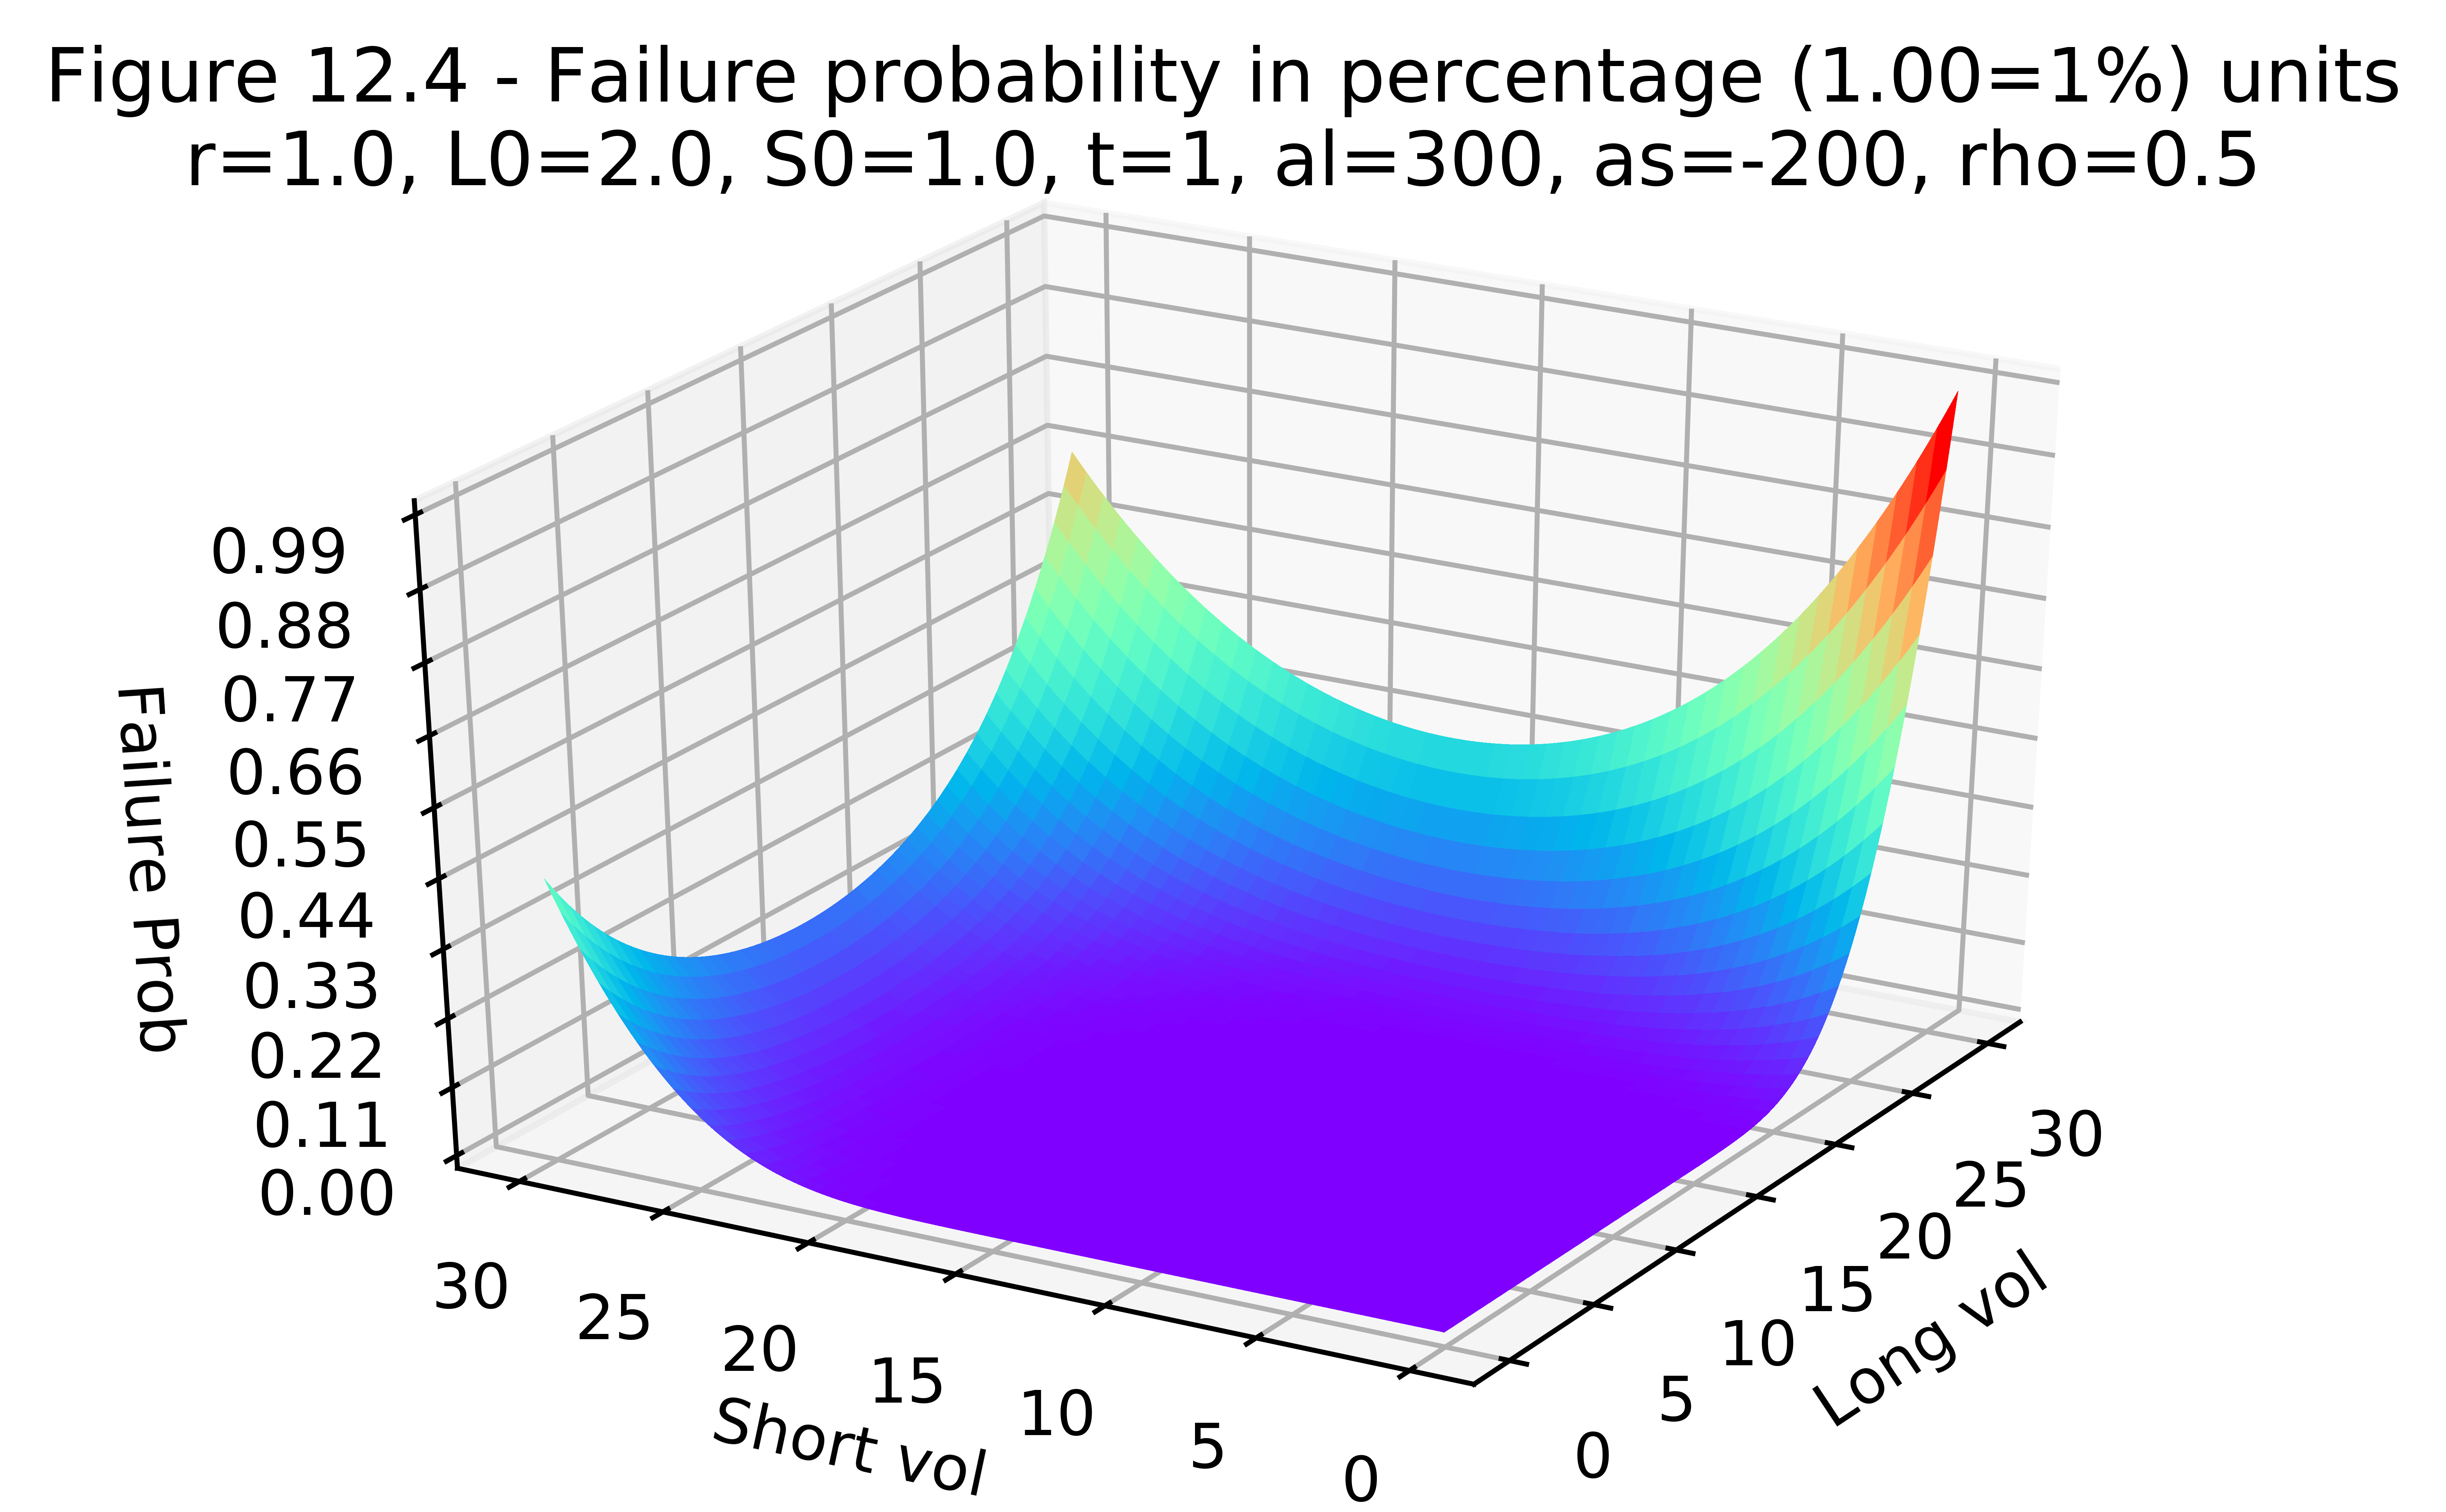

Maximum on graph 0.99


In [190]:
#Failure probability surface using (12.6)
import scipy.stats as spst
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def change_units(alpha_long, alpha_short, sl, ss):
    #change units to fractions
    aal=alpha_long/10**4
    aas=alpha_short/10**4
    slf=sl/100
    ssf=ss/100
    return(aal,aas,slf,ssf)

def fail_prob_12p6(r,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute N(D1), failure probability per formula (12.6)
    #Returns in percentage units (1=1%)
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)
    numer=np.log(L0/S0)-np.log(r)+(aal-aas-slf**2/2+ssf**2/2)*t
    capital_sigma=np.sqrt(slf**2-2*rho*slf*ssf+ssf**2)
    D1=numer/(capital_sigma*np.sqrt(t))
    return(spst.norm.cdf(-D1)*100)

def ThreeD_Prob_Graph(r_or_k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob,str_title):
    #Draw a 3D probability graph illustrating one ore more formulas
    
    sigma_l = np.arange(.1,30.1,.1)   #long side standard deviation
    sigma_s = np.arange(.1,30.1,.1)   #short side standard deviation

    #draw surface
    fig = plt.figure(dpi=1200)
    ax = fig.gca(projection='3d')

    # Make data.
    X = sigma_l
    Y = sigma_s
    X, Y = np.meshgrid(X, Y)
    Z = fail_prob(r_or_k,S0,L0,t,alpha_long,alpha_short,rho,X,Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
        linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(ax.elev, ax.azim-90)

    #Label axes
    ax.set_xlabel('Long vol')
    ax.set_ylabel('Short vol')
    ax.set_zlabel('Failure Prob')

    #Add parameters to title
    s_title=str_title
    if r_or_k >= 1:
        #This is a ratio
        s_title+="\nr=%1.1f" % r_or_k
    else:
        #This is an additive barrier 
        s_title+="\nk=%1.1f" % r_or_k
    s_title+=", L0=%1.1f" % L0
    s_title+=", S0=%1.1f" % S0
    s_title+=", t=%1.f" % t
    s_title+=", al=%3.f" % alpha_long
    s_title+=", as=%3.f" % alpha_short
    s_title+=", rho=%1.1f" % rho
    plt.title(s_title)

    plt.show();
    print("Maximum on graph %.2f" % np.max(Z))
    return

#parameters
r=1    #failure point when ratio of longs to shorts is r or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.4 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(r,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p6,str_title)

The parameters used here include:
- Initial leverage of $\lambda=3$; $L(0)=2$ and $S(0)=1$
- 1 year time period
- Skilled manager with $\alpha_L=300$bps skill at picking good longs and $-\alpha_S=200$bps skill at picking bad shorts
- $\rho=.5$ correlation between the longs and the shorts.

The **`leverage`** figure of $\lambda=3$ is obtained by dividing the sum of the longs and the shorts by their difference, $\lambda=\frac{L(0)+S(0)}{L(0)-S(0)}$. We will assume an initial budget constraint $L(0)-S(0)=1$, although as time goes on the value of the long/short portfolio $L(T)-S(T)$ will differ from $1$.

The back walls of Figure 12.4 (where $\sigma_L=30\%$ or $\sigma_S=30\%$) show nonlinear responses to increasing the non-fixed volatility. For example when $\sigma_L$ is fixed at $30\%$, increasing short volatility $\sigma_S$ improves (lowers) failure probability up to about $\sigma_S=15\%$. This is a result of the interplay between the parameters of $D_1$ in \eqref{eq:ratio_dist_def}.

The general takeaway from Figure 12.4 is that failure probabilities are mild (less than $1\%$) for these parameters when volatilities are in the usual range for equity portfolios.

However, Figure 12.4 and formula \eqref{eq:ratio_dist_def} ignore the fact that there is no recovery from bankruptcy. If $L(t)-S(t)<0$, the portfolio will not be able to continue. Consider Figure 12.5: 

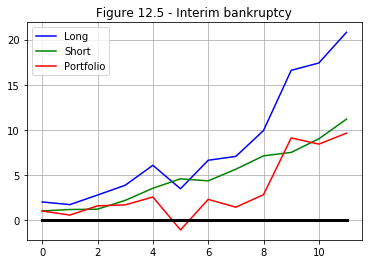

In [191]:
#Show a bankruptcy path

long_val=[2,1.70349709,2.765801055,3.850051243,6.063479723,3.463569566, \
          6.624307423,7.052584477,9.923217173,16.59526583,17.41394079, \
          20.82226825]

short_val=[1,1.160855135,1.198217224,2.175223753,3.515803107,4.565359589, \
           4.338130909,5.634338638,7.113298131,7.495123468,8.999852245, \
           11.19045274]

port_val=np.subtract(long_val,short_val)

nobs=len(port_val)
x=np.arange(0,nobs)

plt.plot(x,long_val,color='b',label="Long")
plt.plot(x,short_val,color='g',label='Short')
plt.plot(x,port_val,color='r',label='Portfolio')
plt.plot(x,[0]*nobs,color='k',linewidth=3)
plt.legend()
plt.grid()
plt.title("Figure 12.5 - Interim bankruptcy")
plt.show();

In period 5 in Figure 12.5, the value of the <span style="color:green">green short portfolio $S(5)$ </span> exceeds the value of the <span style="color:blue">blue long portfolio $L(5)$ </span> so the <span style="color:red">red overall portfolio $L(5)-S(5)$ </span> goes negative. The subsequent periods are fictional: the fund would not be allowed to continue by its lenders after period $5$. In practice the fund may have to stop operations before $L(t)<S(t)$ as new lenders may refuse to lend without better short side coverage.

Once again this is similar to credit modeling. Consider the time to failure
$$\tau_r=\text{Inf}\{t:t>0,\frac{L(t)}{S(t)}\leq r\}\label{eq:time_to_failure}\tag{12.7}$$
$Pr(\tau_r>T)$ is a more accurate assessment of failure probability than \eqref{eq:ratio_dist_def}.

The solutions to such absorbing barrier or first passage time problems are well known. We invoke a result of this type from Musiela and Rutkowski:[$^3$](#twelve_footnotes)
>Corollary: Let g=at+sW be an arithmetic Brownian motion driven by a Wiener process W, and let
$$m_T^g=\text{Inf}_{u\in[0,T]}\{g(u)\}$$
Then for every y<0,
$$Pr(m_T^g\geq y)=N\bigl(\frac{-y+aT}{s\sqrt{T}}\bigr)-exp(2ay/s^2)N\bigl(\frac{y+aT}{s\sqrt{T}}\bigr)$$

The first term $N\bigl(\frac{-y+aT}{s\sqrt{T}}\bigr)$ is simply the probability that $g(T)\geq y$, similar to \eqref{eq:ratio_dist_def}.

The subtracted second term removes the probability that the barrier $y<0$ is hit at some interim time $s\in(0,T)$. This second term is the result of  the **`reflection principle`**, which notes a 1-1 correspondence between (a) paths like the red path in Figure 12.5; and (b) paths that are the mirror image of the red path (reflected about the x axis) up to the first time the red path touches the x axis, and identical to the red path thereafter.

More precisely, if $W$ is a standard Wiener process ($W_0=0$, iid normal increments with mean 0, variance $dt$), then the following is true about the joint distribution between $W$ and the inf $m_T^W=\text{Inf}_{u\in[0,T]}\{W(u)\}$ when $y<0, y<x$:
>Result 1: $\qquad Pr(W_T\geq x, m_T^W< y)=Pr(W_T\geq x-2y)=Pr(W_T\leq 2y-x)$

(This is similar to Musiela and Rutkowski, Lemma B.3.1). This follows from defining $V=W-y$ so that $V_0=-y>0$; then $Pr(W_T\geq x, m_T^W<y)=Pr(V_T\geq x-y, m_T^V< 0)$. The reflection principle comes into play: for each V-path with $m_T^V<0$, there must be a first time $T_{0,V}$ where $V_{T_{0,V}}=0$. Let $R$ be the reflection of the V-path about the x axis from time $0$ to time $T_{0,V}$, and then the V-path thereafter. $R$ starts at $y<0$ and ends at or above $x-y>0$. Thus there is a $1-1$ correspondence between all paths in the event $R_0=y, R_T\geq x-y$ and the paths in the event $V_0=y, V_T\geq x-y, m_T^V< 0$. Translating the R-paths up by $-y$ shows that the event $W_T\geq x-2y$ is also in $1-1$ correspondence, proving the first equality of Result 1. The second equality follows from symmetry.

When there is a drift $a$ as in the Corollary above, Girsanov's Theorem comes into play. Girsanov's Theorem is often invoked to compute quantities under a change of probability measure, such as the change from risk-neutral to physical probability. Musiela & Rutkowski use Girsanov's Theorem to prove (Lemma B.3.2) a version of the following:[$^4$](#twelve_footnotes)
>Result 2: Let $g=at+sW$ as in the Corollary. Then $Pr(g_T\geq x, m_T^g<y)=exp(2ay/s^2)Pr(g_T\geq 2y-x+aT)$ where $y<0$ and $x>y$.

The Corollary follows from Result 2. Translating to our notation gives
- $g(t)=ln\bigl(\frac{L(t)}{S(t)}\bigr)-ln\bigl(\frac{L(0)}{S(0)}\bigr)$;
- $y=-ln\bigl(\frac{L(0)}{S(0)}\bigr)+ln(r)$;
- $a=\alpha_L-\frac{\sigma_L^2}{2}-\alpha_s+\frac{\sigma_S^2}{2}=A-\frac{\Sigma^2}{2}$;
- $s=\Sigma$

Taking $1-Pr(m_T^g\geq y)$ gives the desired probability of failure including interim failure:
$$Pr(\tau_r\leq T)=N(-D_1)+\bigl(\frac{L(0)}{rS(0)}\bigr)^{1-\frac{2A}{\Sigma^2}}N(D_2)$$
$$where\quad D_2=\frac{-ln\bigr(\frac{L(0)}{S(0)}\bigr)+ln(r)+\bigl(\alpha_L-\frac{\sigma_L^2}{2}-\alpha_s+\frac{\sigma_S^2}{2}\bigr)T}{\Sigma\sqrt{T}}
\label{eq:ratio_barrier_def}\tag{12.8}$$

$\Sigma$ and $A$ are defined in \eqref{GBM_log_diff} and \eqref{GBM_ratio}; $D_1$ is as defined in \eqref{eq:ratio_dist_def}.

Note that \eqref{eq:ratio_barrier_def} incorporates $N(-D_1)$, the non-barrier probability of failure from \eqref{eq:ratio_dist_def}, plus a new term that adds the probability of interim failure. Figure 12.6 shows the failure surface including these new ways to fail:

In [ ]:
#Draw failure probability with absorbing barrier

def fail_prob_12p8(r,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute failure probability per formula (12.8)
    #Includes fail_prob_12p6 plus additional term
    #Returns in percentage units (1=1%)
    
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)
    numer=np.log(r*S0/L0)-(aal-aas-slf**2/2+ssf**2/2)*t
    capital_sigma=np.sqrt(slf**2-2*rho*slf*ssf+ssf**2)
    D1=numer/(capital_sigma*np.sqrt(t))
    
    #Compute A, which is modified alpha
    capital_a=aal-aas+ssf**2-rho*ssf*slf
    D2=D1+2*(capital_a-capital_sigma**2/2)*np.sqrt(t)/capital_sigma
    extra_prob=(L0/(r*S0))**(1-2*capital_a/capital_sigma**2)* \
        spst.norm.cdf(D2)
    
    return((spst.norm.cdf(D1)+extra_prob)*100)

#parameters same as 12.6
str_title="Figure 12.6 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(r,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p8,str_title)

The surface has a similar shape to the one in Figure 12.5, but is roughly double in height. Qualitatively the story is similar: relatively mild chances of default; nonlinear responses to increasing volatility.

## 12.3 Difference Analysis ##

Ratio analysis is tractable and gives a simple view of how a long/short portfolio might avoid (or get into) trouble. But there's a flaw in this way of approaching long/short failure.

Consider a long/short portfolio that starts out with a $\$100,000,000$ investment. The manager borrows another $\$100,000,000$ worth of stock that she doesn't like and sells the shares; the proceeds are then used to buy more stocks that she does like. So her initial portfolio has $L(0)=\$200,000,000$ and $S(0)=\$100,000,000$, for a ratio $\frac{L(0)}{S(0)}=2$.

Suppose the manager is aware of \eqref{eq:ratio_barrier_def} and makes sure that she keeps her ratio $\frac{L(t)}{S(t)}$ greater than $2$ at all times. Some time later, at $T=1$, she is happy to see that $\frac{L(T)}{S(T)}=3$; she is far away from bankruptcy. However she is shocked when her clients all fire her because $L(T)=\$.03$ and $S(T)=\$.01$. The portfolio value $L(t)-S(t)$ has lost almost the entire initial $\$100,000,000$ invested by clients.

So ratios alone are not enough. We need to return to the true portfolio value at time $T$, i.e. the difference $L(T)-S(T)$.

Is it possible to use the mechanism developed to deal with long/short ratios? A little manipulation of a difference can produce ratios. For example, assume the initial budget constraint $L(0)-S(0)=1$ and let $0<k<1$ be some minimally acceptable fraction of initial wealth. The relevant failure probability can be written (and rewritten):
$$Pr(L(T)-S(T)\leq k)=Pr\bigl(\frac{L(T)}{S(T)+k}\leq 1\bigr)=Pr\bigl(\frac{L(T)-k}{S(T)}\leq 1\bigr)\label{eq:diff_probs}\tag{12.9}$$

The two expressions on the right of \eqref{eq:diff_probs} involve ratios, so it might be tempting to try to apply the ratio analysis from above. Unfortunately, offsetting a GBM by a constant does not produce a GBM. There is no closed form for a GBM offset by a constant. Fortunately, there's a clever approximation due to E. Kirk[$^5$](#twelve_footnotes) that is helpful in this situation.

Kirk's approximation was developed to price energy options; it's generally used in pricing spread options where there is some kind of fixed offset. He used a technique called "freezing" in which stochastic quantities are set to the original (constant) value at time $0$ rather than being allowed to vary. In the current context the freeze is the transition from the <span style="color:red">red quantity</span> to the <span style="color:green">green quantity</span>:
$$\frac{d(S+k)}{S+k}=\frac{S}{S+k}\frac{dS}{S}=\color{red}{\frac{S}{S+k}}(\alpha_Sdt+\sigma_SdZ_S)$$
$$=\color{green}{\frac{S(0)}{S(0)+k}}(\alpha_Sdt+\sigma_SdZ_S)\label{eq:kirk_freeze}\tag{12.10}$$

The first line of \eqref{eq:kirk_freeze} is intractable, but the second line is just a scaled version of standard GBM. Thus the approximation says that $ln(S(T)+k)$ is normally distributed with mean $\bigl(\alpha_S^{\prime}-\frac{(\sigma_S^{\prime})^2}{2}\bigr)T$ and standard deviation $\sigma_S^{\prime}$, where $\alpha_S^{\prime}=\frac{S(0)}{S(0)+k}\alpha_S$ and $\sigma_S^{\prime}=\frac{S(0)}{S(0)+k}\sigma_S$.



The Kirk approximation \eqref{eq:kirk_freeze} means that \eqref{eq:ratio_dist_def} can be adapted:

$$Pr(\frac{L(T)}{S(T)+k}<1)=Pr\bigl(ln\bigl(\frac{L(T)}{S(T)+k}\bigr)<0\bigr)\approx N(-\hat{D}_1(k))$$
$$where\quad SF=\frac{S(0)}{S(0)+k};\quad \hat{A}(k)=\alpha_L-SF\alpha_S+(SF)^2\sigma_S^2-SF\rho\sigma_L\sigma_S;$$
$$\hat{\Sigma}(k)^2=\sigma_L^2-2SF\rho\sigma_L\sigma_S+(SF)^2\sigma_S^2;$$
$$\hat{D}_1(k)=\frac{ln\bigl(\frac{L(0)}{S(0)+k}\bigr)+\bigl(\hat{A}(k)-\frac{\hat{\Sigma}(k)^2}{2}\bigr)T}{\hat{\Sigma}(k)\sqrt{T}}\label{eq:kirk_dist_def}\tag{12.11}$$

The first time to default can be redefined from the ratio-based \eqref{eq:time_to_failure} to a difference-based version:
$$\tau_k=\text{Inf}\{t:t>0,L(t)-S(t)\leq k\}\label{time_to_failure_k}\tag{12.12}$$
The absorbing barrier solution \eqref{eq:ratio_barrier_def} can also be adapted:
$$Pr(\tau_k\leq T)\approx N(-\hat{D}_1(k))+\bigl(\frac{L(0)}{S(0)+k}\bigr)^{1-\frac{2\hat{A}(k)}{\hat{\Sigma}(k)^2}}N(\hat{D}_2(k))$$
$$where\quad \hat{D}_2(k)=\frac{-ln\bigr(\frac{L(0)}{S(0)+k}\bigr)+\bigl(\hat{A}(k)-\frac{\hat{\Sigma}(k)^2}{2}\bigr)T}{\hat{\Sigma}(k)\sqrt{T}}
\label{eq:kirk_barrier_def}\tag{12.13}$$

Unfortunately the results are discouraging as shown in Figure 12.7:

In [ ]:
#Draw failure probability with difference (Kirk approximation)

def fail_prob_12p13(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute failure probability per formula (12.13)
    #Returns in percentage units (1=1%)
    
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)

    #Following (12.11) notation
    SF=S0/(S0+k)
    a_hat_k=aal-SF*aas+(SF*ssf)**2-SF*rho*ssf*slf
    sigma_hat_k_sq=slf**2+(SF*ssf)**2-2*SF*rho*ssf*slf
    
    numer1=np.log(L0/(S0+k))+(a_hat_k-sigma_hat_k_sq/2)*t
    D1_hat_k=numer1/np.sqrt(sigma_hat_k_sq*t)
    numer2=-np.log(L0/(S0+k))+(a_hat_k-sigma_hat_k_sq/2)*t
    D2_hat_k=numer2/np.sqrt(sigma_hat_k_sq*t)
    
    extra_prob=(L0/(S0+k))**(1-2*a_hat_k/sigma_hat_k_sq)* \
        spst.norm.cdf(D2_hat_k)
    
    return((spst.norm.cdf(-D1_hat_k)+extra_prob)*100)

#parameters
k=.5    #failure point when L-S is k or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.7 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

There is almost $34\%$ chance of failure at the peak, which is where short volatility is low and long volatility is high. A lot of manager skill has been assumed: $500$bps overall skill between the long side and the short side, which is extremely generous. The range of volatilities shown is reasonable for equity long/short portfolios; fixed income long-short portfolios might be in the safer blue area of the graph, but the ability to extract outperformance ($\alpha_L$ and $\alpha_S$) would probability be lower.

The next several graphs will show the failure surface's response to changing various inputs.

In [ ]:
#Same as previous, change leverage down to 1.5 long, .5 short

#parameters
k=.5    #failure point when L-S is k or less
S0=.5   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.8 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

As one would expect, lowering initial leverage is helpful in lowering the failure probabilities. In Figure 12.8 an initial leverage of $\frac{1.5+.5}{1.5-.5}=2$ was used, which is more moderate than the $\frac{2+1}{2-1}=3$ leverage that was used in Figure 12.7. This almost halved failure probabilities.

In [ ]:
#Same as previous, change leverage up to 4.5 long, 3.5 short

#parameters
k=.5    #failure point when L-S is k or less
S0=3.5   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.9 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

Figure 12.9 shows that increasing leverage to $\frac{4.5+3.5}{4.5-3.5}=8$ does what one would expect: failure probabilities become sky-high for all but the lowest volatility portfolios. Leverage of $8$ is not unheard of for aggressive hedge funds.

In [ ]:
#Back to moderate leverage, k=.9

#parameters
k=.9    #failure point when L-S is k or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.10 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

In Figure 12.10 the failure threshold was raised from $k=.5$ to $k=.9$; that is, failure occurs when $10\%$ of the original capital is lost as opposed to the $50\%$ loss that was tolerated previously. As one would expect, this also causes failure probabilities to skyrocket. Only very low volatility portfolios would make sense with such a low loss tolerance.

In [ ]:
#Back to k=.5; rho=.9

#parameters
k=.5    #failure point when L-S is k or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.9  #long/short correlation
str_title="Figure 12.11 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

Figure 12.11 restores the failure point to $k=.5$ but increases the correlation between longs and shorts from $\rho=.5$ in previous examples to $\rho=.9$. This failure surface has the same high point as Figure 12.7, but is considerably improved elsewhere. High long-short correlation is good, which may be unintuitive at first. We are used to looking for low correlation when forming diversified portfolios, but the minus sign in front of the short position means high correlation is preferred.

In [ ]:
#rho=-.5

#parameters
k=.5    #failure point when L-S is k or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=-.5  #long/short correlation
str_title="Figure 12.12 - Failure probability in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_12p13,str_title)

Figure 12.12 was generated with a correlation $\rho=-.5$, showing again that long/short portfolios turn correlation upside down. In a long-only portfolio negative correlation would be highly desirable; here it makes things worse.

## 12.4 Long/short risk management techniques ##

The examples show that unmanaged long/short portfolios can have large chances of unacceptable drawdowns. The conclusion is the same as the doctor's advice at the beginning of Chapter 11: stay out of those places. These calculations show that most long/short portfolios can't be left unmanaged for a year.

The risk management interval needs to be shortened, thus reducing the risk of unacceptable drawdown. But what should be done at the end of each of the shorter intervals? A number of techniques are in use to try to maximize success while minimizing the chance of an unacceptable drawdon:
- Maintain constant leverage
- Stop losses; various forms of put replication
- Set VaR limits
- Set limits on overall portfolio volatility ($\Sigma$ in \eqref{GBM_log_diff})
- Maintain large cash balances
- Lower volatility or increase long/short correlation

The first two techniques seek to control outputs: they prescribe trading strategies that must be carried out based only on the levels of $L(T)$ and $S(T)$. The last four techniques seek to control inputs: adjustments are made based on the characteristics of the long and short (or combined) portfolios.

One goal for any of these techniques should be to avoid if possible procyclical trading. Stop losses, which move all or part of the portfolio into cash after some losses have occurred, are inherently procyclical. That is, a stop loss technique calls for selling assets because they have gone down in price and/or buying (short) assets because they have gone up in price. This can cause price gapping especially if others are pursuing the same strategy.

No long/short technique is always countercyclical, but maintaining constant leverage is generally reasonable. For example, a portfolio maintaining constant leverage of $3$ might start out at time $0$ with $L(0)=2$ and $S(0)=1$. Suppose that the overall market is generally up and a short time later (time $t$), the components have moved:
- Longs are up $10\%$ of overall value from $2$ to $2.1$;
- Shorts are up $6\%$ of overall value from $1$ to $1.06$;

The overall portfolio is now $L(t)-S(t)=2.1-1.06=1.04$, up $4\%$. Longs are now $2.019$ times the portfolio value and shorts are now $1.019$ times the portfolio value. Leverage is therefore $2.019+1.019=3.038$, which is higher than desired.

To correct this, $.02$ of longs would be sold and $.02$ of shorts would be bought back, giving $2.08$ longs and $1.04$ shorts, restoring the desired $3$ leverage. The long side sell is countercyclical, but the short buy is procyclical. Some procyclicality can be eliminated by maintaining a cash buffer that increases or decreases as necessary, but eventually a cash buffer can be exhausted or can get too big.

In general to maintain constant leverage, the constant leverage target $\lambda$ is chosen and periodically trades are done so that
$$L_{new}=\frac{\lambda+1}{2}(L-S);\quad S_{new}=\frac{\lambda-1}{2}(L-S)
\label{const_leverage_targets}\tag{12.14}$$
$L_{new}-S_{new}=L-S$, satisfying the budget constraint while adjusting so that $\frac{L_{new}+S_{new}}{L_{new}-S_{new}}=\lambda$.

\eqref{const_leverage_targets} means that the portfolio always consists of $w_1=\frac{\lambda+1}{2}$ longs and $w_2=\frac{1-\lambda}{2}$ shorts. A portfolio $P$ rebalanced to constant weights $w_i$ of asset $X_i$ ($i=1,\dots,n$) where $\sum w_i=1$ has rate of return
$$\frac{dP}{P}=\sum_{i=1}^n w_i\frac{dX_i}{X_i}$$
For the long-short portfolio $n=2$, $X_1=L$, and $X_2=S$:
$$\frac{dP}{P}=\biggl(\frac{\lambda+1}{2}\biggr)\frac{dL}{L}-\biggl(\frac{\lambda-1}{2}\biggr)\frac{dS}{S}\label{eq:const_lev_process}\tag{12.15}$$

Thus maintaining constant leverage allows the long-short portfolio $P=L-S$ to be expressed as a GBM. The parameters follow from the components:
$$\frac{d(L-S)}{L-S}=\alpha_{\lambda}dt+\sigma_{\lambda}dZ;$$
$$where\quad \alpha_{\lambda}=
\biggl(\frac{\lambda+1}{2}\biggr)\alpha_L-\biggl(\frac{\lambda-1}{2}\biggr)\alpha_S$$
$$and\quad
\sigma_{\lambda}^2=\frac{1}{4}\biggl(
\bigl(\lambda+1\bigr)^2\sigma_L^2
-2\bigl(\lambda^2-1\bigr)\rho\sigma_L\sigma_S
+\bigl(\lambda-1\bigr)^2\sigma_S^2
\biggr)
\label{eq:lambda_process}\tag{12.16}$$

Note that $\alpha_{\lambda}$ and $\sigma_{\lambda}$ are linear in $\lambda$. So the growth rate of the constant leverage portfolio $\alpha_{lambda}-\frac{\sigma_{\lambda}^2}{2}$ becomes negative for large enough $\lambda$, confirming the intuition that a lot of leverage is dangerous. \eqref{eq:lambda_process} can be applied to \eqref{eq:kirk_dist_def} to obtain
$$Pr_{const \lambda}(L(T)-S(T)\leq k)=Pr_{const \lambda}(ln(L(T)-S(T))\leq ln(k))=N(-D_{\lambda,1})$$
$$where\quad
D_{\lambda,1}=
\frac{
ln\bigl(\frac{L(0)-S(0)}{k}\bigr)+\bigr(\alpha_{\lambda}-\frac{\sigma_{\lambda}^2}{2}\bigl)T
}
{\sigma_{\lambda}\sqrt{T}}
\label{eq:lambda_dist_nobarrier}\tag{12.17}$$

Incorporating the interim absorbing barrier gives failure probability
$$1-Pr_{const \lambda}(L(t)-S(t)\geq k \,\forall\, 0\leq t\leq T)=N(-D_{\lambda,1})+
\bigl(\frac{L(0)-S(0)}{k}\bigr)^{1-\frac{2\alpha_{\lambda}}{\sigma_{\lambda}^2}}N(D_{\lambda,2)}$$
$$where\quad
D_{\lambda,2}=
\frac{
-ln\bigl(\frac{L(0)-S(0)}{k}\bigr)+\bigr(\alpha_{\lambda}-\frac{\sigma_{\lambda}^2}{2}\bigl)T
}
{\sigma_{\lambda}\sqrt{T}}
\label{eq:lambda_dist_barrier}\tag{12.18}$$

Figure 12.13 shows the difference in failure probability between the unmanaged portfolio (using \eqref{eq:kirk_barrier_def}) and the portfolio managed to constant leverage (\eqref{eq:lambda_dist_barrier}):

In [ ]:
#Show difference between managed constant-leverage (12.18)
#and unmanaged (12.13)

def fail_prob_12p18(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute failure probability per formula (12.18)
    #(which is success formula, so take complement)
    #Returns in percentage units (1=1%)
    
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)
    tiny=10**(-32)

    #Following (12.16) notation
    lam=(L0+S0)/(L0-S0)   #The leverage being held constant
    alpha_lam=((lam+1)*aal-(lam-1)*aas)/2
    sigma_lam_sq=((lam+1)*slf)**2-2*(lam**2-1)*slf*ssf*rho+((lam-1)*ssf)**2
    sigma_lam_sq/=4
    
    #Following (12.17) notation
    D_lam_1=np.log(L0-S0)-np.log(k+tiny)+(alpha_lam-sigma_lam_sq/2)*t  #numerator
    D_lam_1/=np.sqrt(sigma_lam_sq*t)                 #denominator
    
    #Following (12.18)
    D_lam_2=-D_lam_1+2*(alpha_lam-sigma_lam_sq/2)*np.sqrt(t/sigma_lam_sq)
    
    first_term=spst.norm.cdf(-D_lam_1)
    second_term=((L0-S0)/(k+tiny))**(1-2*alpha_lam/sigma_lam_sq)* \
        spst.norm.cdf(D_lam_2)
    
    return((first_term+second_term)*100)

def fail_prob_diff(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    unmanaged=fail_prob_12p13(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss)
    managed=fail_prob_12p18(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss)
    return(unmanaged-managed)

#parameters
k=.5    #failure point when L-S is k or less
S0=1   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.5  #long/short correlation
str_title="Figure 12.13 - Unmanaged-managed failure probability\n"
str_title+="in percentage (1.00=1%) units"

ThreeD_Prob_Graph(k,S0,L0,t,alpha_long, \
                  alpha_short,rho,fail_prob_diff,str_title)

## 12.5 Success probabilities ##

The constant leverage technique lowers failure probability as shown in Figure 12.13. There's an even better way to lower failure probability: hold only cash. Looking only at failure probabilities puts a manager on the grumpy side of life: we need to think about success. Or, to put it in double-negative terms, we need to think about the cost of lowering the failure probability.

Thus the conditional cdf
$$P(K,k)=Pr(L(T)-S(T)\leq K | L(t)-S(t)\geq k \,\forall\, 0\leq t\leq T)$$
needs to be analyzed; this gives information on how well the portfolio can do ($K$) assuming it stays out of trouble ($k<K$).

For this section, define
$$f(t)=\frac{L(t)}{S(t)+k}$$
$$F(t)=\frac{L(t)}{S(t)+K}$$
$$g(t)=-ln\biggl(\frac{f(t)}{f(0)}\biggr)$$
$$G(t)=ln\biggl(\frac{F(t)}{F(0)}\biggr)$$
Using the Kirk approximation, we have
$$dg\approx\bigl(-\hat{A}(k)+\hat{\Sigma}(k)^2/2\bigr)dt+\hat{\sigma}(k)dZ_g$$
$$dG\approx\bigl(\hat{A}(K)-\hat{\Sigma}(K)^2/2\bigr)dt+\hat{\sigma}(K)dZ_G$$
where $\hat{A}(k)$ is defined in \eqref{eq:kirk_dist_def} and $\hat{A}(K)$ is defined similarly with $K$ replacing $k$ in the $SF$ factor. Further,
$$\hat{\Sigma}(k)dZ_g=-\sigma_LdZ_L+\frac{\sigma_SS(0)}{S(0)+k}dZ_S$$
$$\hat{\Sigma}(K)dZ_g=\sigma_LdZ_L-\frac{\sigma_SS(0)}{S(0)+K}dZ_S$$
Note this is the same $\hat{\Sigma}(k)$ that was defined in \eqref{eq:kirk_dist_def}.

In this notation, the desired conditional cdf can be rewritten
$$P(K,k)=Pr(G(T)\leq -ln(F(0)) \,|\, Max_{t\in[0,T]}\{g(t)\}\leq f(0))$$

To solve this, we invoke a result from [H. Lee 2004](https://www.koreascience.or.kr/article/JAKO200411922381481.j):
>Let $(X_1,X_2)$ be a bivariate linear Brownian motion with mean vector $(\mu_1,\mu_2)$ and covariance structure
$$
  \left[ {\begin{array}{cc}
   \sigma_1^2 & \psi\sigma_1\sigma_2\\
   \psi\sigma_1\sigma_2 & \sigma_2^2\\
  \end{array} } \right]
$$
Let $M_2(s,t)=Max_{\tau\in[s,t]}\{X_2(\tau)\}$. Then
$$Pr(X_1(T)\leq x,M_2(s,t)\leq m)=$$
$$\Phi_3
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}},
\frac{m-\mu_2t}{\sigma_2\sqrt{t}},
\frac{m-\mu_2s}{\sigma_2\sqrt{s}},
\psi\sqrt{\frac{t}{T}},
\psi\sqrt{\frac{s}{T}},
\sqrt{\frac{s}{T}}
\biggr)$$
$$-exp\bigl(\frac{2\mu_2 m}{\sigma_2^2}\bigr)
\Phi_3
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}}-\frac{2\psi m}{\sigma_2\sqrt{T}},
\frac{-m-\mu_2t}{\sigma_2\sqrt{t}},
\frac{m+\mu_2s}{\sigma_2\sqrt{s}},
\psi\sqrt{\frac{t}{T}},
-\psi\sqrt{\frac{s}{T}},
\sqrt{\frac{s}{T}}
\biggr)
$$
where $\Phi_3(a,b,c,\rho_{12},\rho_{13},\rho_{23})=Pr(Z_1\leq a,Z_1\leq b, Z_3\leq c)$ is the cdf for the trivariate standard normal distribution with correlation matrix
$$
  \left[ {\begin{array}{ccc}
   1 & \rho_{12} & \rho_{13}\\
   \rho_{12} & 1 &\rho_{23}\\
   \rho_{13} & \rho_{23} & 1\\
  \end{array} } \right]
$$

To get the inputs for Lee's result, it is necessary to compute the correlation between $dZ_g$ and $dZ_G$:
$$\hat{R}\equiv Corr(dZ_g,dZ_G)$$
$$=\frac{-1}{\hat{\Sigma}(k)\hat{\Sigma}(k)}
\biggl[
\sigma_L^2-\rho\sigma_L\sigma_SS(0)
\bigl(\frac{1}{S(0)+k}+\frac{1}{S(0)+K}
\bigr)
+\frac{\sigma_S^2S(0)^2}
{(S(0)+k)(S(0)+K)}
\biggr]
$$

The translation table looks like this:
- $X_1(u)=G=ln\bigl(\frac{L(u)}{S(u)+K}\bigr)-ln\bigl(\frac{L(0)}{S(0)+K}\bigr)$
- $X_2(u)=g=ln\bigl(\frac{L(0)}{S(0)+k}\bigr)-ln\bigl(\frac{L(u)}{S(u)+k}\bigr)$
- $x = -ln(F(0))=-ln\bigl(\frac{L(0)}{S(0)+K}\bigr)$
- $m = ln(f(0))=ln\bigl(\frac{L(0)}{S(0)+k}\bigr)$
- $s=0$
- $t=T$
- $\mu_1=\hat{A}(K)-\hat{\Sigma}(K)^2/2=\alpha_L-\frac{\sigma_L^2}{2}-\frac{S(0)}{S(0)+K}\alpha_S+\frac{S(0)^2}{(S(0)+K)^2}\frac{\sigma_S^2}{2}$
- $\mu_2=-\hat{A}(k)+\hat{\Sigma}(k)^2/2=-\alpha_L+\frac{\sigma_L^2}{2}+\frac{S(0)}{S(0)+k}\alpha_S-\frac{S(0)^2}{(S(0)+k)^2}\frac{\sigma_S^2}{2}$
- $\sigma_1=\hat{\Sigma}(K)=\sqrt{
\sigma_L^2-
2\frac{S(0)}{S(0)+K}\rho\sigma_L\sigma_s+\frac{S(0)^2}{(S(0)+K)^2}\sigma_S^2
}$
- $\sigma_2=\hat{\Sigma}(k)=\sqrt{
\sigma_L^2-
2\frac{S(0)}{S(0)+k}\rho\sigma_L\sigma_s+\frac{S(0)^2}{(S(0)+k)^2}\sigma_S^2
}$
- $\psi = \hat{R}$

Applying Lee's result gives
$$Pr(X_1(t)\leq x,M_2(0,T)\leq m)=$$
$$\Phi_3
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}},
\frac{m-\mu_2T}{\sigma_2\sqrt{T}},
sgn(m)\infty,
\psi,
0,
0
\biggr)$$
$$-exp\bigl(\frac{2\mu_2 m}{\sigma_2^2}\bigr)
\Phi_3
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}}-\frac{2\psi m}{\sigma_2\sqrt{T}},
\frac{-m-\mu_2T}{\sigma_2\sqrt{T}},
sgn(m)\infty,
\psi,
0,
0
\biggr)
$$

Because of the infinite argument ($sgn(m)=1$) in the third variable, the trivariate normal fortunately reduces to a bivariate normal:
$$Pr(X_1(t)\leq x,M_2(0,T)\leq m)=$$
$$\Phi_2
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}},
\frac{m-\mu_2T}{\sigma_2\sqrt{T}},
\psi
\biggr)$$
$$-exp\bigl(\frac{2\mu_2 m}{\sigma_2^2}\bigr)
\Phi_2
\biggl(
\frac{x-\mu_1T}{\sigma_1\sqrt{T}}-\frac{2\psi m}{\sigma_2\sqrt{T}},
\frac{-m-\mu_2T}{\sigma_2\sqrt{T}},
\psi
\biggr)
$$

Translating back to the original notation results in
$$P(K,k)\approx$$
$$\Phi_2
\biggl(
-\hat{D}_1(K),
\hat{D}_1(k),
\hat{R}
\biggr)$$
$$-\bigl(\frac{L(0)}{S(0)+k}\bigr)
^{
1-\frac{2\hat{A}(k)}{\hat{\Sigma}(k)^2}
}
\Phi_2
\biggl(
-\hat{D}_1(K)-
\frac{2\hat{R}ln\bigl(\frac{L(0)}{S(0)+k}\bigr)}
{\hat{\Sigma}(k)\sqrt{T}},
\hat{D}_2(k),
\hat{R}
\biggr)
\label{eq:bivariate_cdf}\tag{12.30}
$$
Here $\hat{D}_i(k)$ ($i=1,2)$ are the same as in \eqref{eq:kirk_dist_def} and \eqref{eq:kirk_barrier_def}, with the obvious substitutions giving $\hat{D}_i(K)$ ($i=1,2)$.

Note that $\text{lim}_{K\to\infty}\hat{D}_1(K)=-\infty$ so
$$\lim_{K\to\infty}P(K,k)\approx$$
$$\Phi_2
\biggl(
\infty,
\hat{D}_1(k),
\hat{R}
\biggr)$$
$$-\bigl(\frac{L(0)}{S(0)+k}\bigr)
^{
1-\frac{2\hat{A}(k)}{\hat{\Sigma}(k)^2}
}
\Phi_2
\biggl(
\infty,
\hat{D}_2(k),
\hat{R}
\biggr)
\label{eq:bivariate_def_Kinf}\tag{12.31}
$$
The bivariate normals reduce to univariate normals, so \eqref{eq:bivariate_def_Kinf} is the same as one minus \eqref{eq:kirk_barrier_def}.

Success &mdash; exceeding $K$ at time $T$ while never going below $k<K$ in the interval $[0,T]$ &mdash; is
$$S(K,k,T)=Pr(L(T)-S(T)\geq K | L(t)-S(t)\geq k \,\forall\, 0\leq t\leq T)$$
$$=1-Pr(\tau_k\leq T)-P(K,k)\label{eq:success_K_k}\tag{12.32}$$
$Pr(\tau_k\leq T)$ is from \eqref{eq:kirk_barrier_def} and $P(K,k)$ is from \eqref{eq:bivariate_cdf}.

Figure 12.20 shows the success probability surface \eqref{success_K_k} as a function of $K$ and $k$, using the parameters shown in the graph title.

In [ ]:
#Show success surface (12.32)

def success_prob_12p32(k,K,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute success probability per formula (12.32)
    #Returns in percentage units (1=1%)
    
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)

    #Decide whether call is scalar or array
    scalar = not isinstance(K, (list, tuple, set, np.ndarray))
    
    #Basic adjusted drifts and standard deviations (12.11)
    SF_k=S0/(S0+k)
    a_hat_k=aal-SF_k*aas+(SF_k*ssf)**2-SF_k*rho*ssf*slf
    sigma_hat_k_sq=slf**2+(SF_k*ssf)**2-2*SF_k*rho*ssf*slf
    SF_K=S0/(S0+K)
    a_hat_K=aal-SF_K*aas+(SF_K*ssf)**2-SF_K*rho*ssf*slf
    sigma_hat_K_sq=slf**2+(SF_K*ssf)**2-2*SF_K*rho*ssf*slf
    
    #Adjusted D1 and D2
    D1_hat_k=(np.log(L0/(S0+k))+(a_hat_k-sigma_hat_k_sq/2)*t)/ \
        np.sqrt(sigma_hat_k_sq*t)
    D2_hat_k=(-np.log(L0/(S0+k))+(a_hat_k-sigma_hat_k_sq/2)*t)/ \
        np.sqrt(sigma_hat_k_sq*t)
    D1_hat_K=(np.log(L0/(S0+K))+(a_hat_K-sigma_hat_K_sq/2)*t)/ \
        np.sqrt(sigma_hat_K_sq*t)

    #Adjusted correlation R-hat
    R_hat=-(slf**2-rho*slf*ssf*S0*(1/(S0+k)+1/(S0+K))+ \
        (ssf**2)*S0**2/((S0+k)*(S0+K)))/ \
        np.sqrt(sigma_hat_k_sq*sigma_hat_K_sq)
    
    #Prepare to evaluate (12.30)
    term2_mult=(L0/(S0+k))**(1-2*a_hat_k/sigma_hat_k_sq)     
    term2_arg1=-D1_hat_K-2*R_hat*np.log(L0/(S0+k))/np.sqrt(sigma_hat_k_sq*t)

    #Awkward! section because multivariate normal can't handle arrays
    if scalar:   #No arrays - just feed arguments to mvn
        cov_mtrx=[[1., R_hat], [R_hat, 1.]]
        ft_args=[-D1_hat_K, D1_hat_k]
        first_term=spst.multivariate_normal.cdf( \
            ft_args, mean=None, cov=cov_mtrx, allow_singular=True)
        st_args=[term2_arg1, D2_hat_k]
        second_term=term2_mult*spst.multivariate_normal.cdf( \
            st_args, mean=None, cov=cov_mtrx, allow_singular=True)
        P_K_k=first_term-second_term
        if K<=k: P_K_k=0 #Impossible
    else:
        #multivariate_normal has to be spoon-fed scalars
        #to form terms of (12.30)
        P_K_k=np.zeros(K.shape)
        for i in range(K.shape[0]):
            for j in range(K.shape[1]):
                cov_mtrx=[[1., R_hat[i,j]], [R_hat[i,j], 1.]]
                ft_args=[-D1_hat_K[i,j], D1_hat_k[i,j]]
                first_term=spst.multivariate_normal.cdf( \
                    ft_args, mean=None, cov=cov_mtrx, allow_singular=True)
                st_args=[term2_arg1[i,j], D2_hat_k[i,j]]
                second_term=term2_mult[i,j]*spst.multivariate_normal.cdf( \
                    st_args, mean=None, cov=cov_mtrx, allow_singular=True)
                P_K_k[i,j]=first_term-second_term
                if K[i,j]<=k[i,j]: P_K_k[i,j]=0  #Impossible
    
    #Need to subtract off the other way to fail
    success_prob=100-100*P_K_k- \
        fail_prob_12p13(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss)

    return(success_prob)
#Done with success_prob_12p32

def Success_Prob_Graph(sl,ss,S0,L0,t,alpha_long, \
                  alpha_short,rho,success_prob,str_title,zmin):
    #Draw a 3D probability graph where K and k vary on x and y axes

    ks = np.arange(0,1.05,.05)   #Failure levels
    if zmin==0.:
        Ks = np.arange(1.,3.05,.05)   #Success levels
    else:
        Ks = np.arange(0.,2.05,.05)   #Success levels
        
    #draw surface
    fig = plt.figure(dpi=1200)
    ax = fig.gca(projection='3d')

    # Make data.
    X = ks
    Y = Ks
    X, Y = np.meshgrid(X, Y)
    Z = success_prob(X,Y,S0,L0,t,alpha_long,alpha_short,rho,sl,ss)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
        linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.view_init(ax.elev, ax.azim-90)
    if (zmin==0.):
        ax.set_zlim(0,100.)
        ax.set_zticks(np.arange(0,110,10))
    else:
        ax.set_zlim(zmin,-zmin)
        ax.set_zticks(np.arange(zmin,-zmin+1.,1.))

    #Invert axes if cued with zmin==0
    if zmin==0.:
        ax.set_xlim(ks[-1],ks[0])
        ax.set_ylim(Ks[-1],Ks[0])
        plt.yticks(np.arange(Ks[-1],Ks[0],-.5))   #Make more readable
    else:
        plt.yticks(np.arange(Ks[0],Ks[-1]+.5,.5))

    #Label axes
    ax.set_xlabel('Failure k')
    ax.set_ylabel('Success K')
    ax.set_zlabel('Probability')
    
    #Add parameters to title
    s_title=str_title
    s_title+="\nsl=%1.0f" % sl
    s_title+=", ss=%1.0f" % ss
    s_title+=", L0=%1.1f" % L0
    s_title+=", S0=%1.1f" % S0
    s_title+=", t=%1.f" % t
    s_title+=", al=%3.f" % alpha_long
    s_title+=", as=%3.f" % alpha_short
    s_title+=", rho=%1.1f" % rho
    plt.title(s_title)

    plt.show();
    return
#Done with Success_Prob_Graph

#parameters
S0=.5    #initial short value
L0=S0+1  #initial long value
t=10   #time period
alpha_long = 400    #bps skill on long side
alpha_short = 200   #bps skill on short side; negative is good skill
rho=0  #long/short correlation
str_title="Figure 12.20 - Success probability\n"
str_title+="in percentage (1.00=1%) units"
sigma_long = 20
sigma_short= 15

Success_Prob_Graph(sigma_long,sigma_short,S0,L0,t,alpha_long, \
                  alpha_short,rho,success_prob_12p32,str_title,0.)

Note the back corner of Figure 12.20 where $k=0$ and $K=1$ is just under $60\%$. Thus with these parameters there is only a $40\%$ chance of ending up at par ($K=1$) or better while never going bankrupt. On the other hand, surviving portfolios have reasonably good chances of high returns: The $K=3$, $k=0$ point is about $12\%$, i.e. there's a $12\%$ chance of tripling the original amount without going bankrupt.

We saw above that letting portfolio characteristics be unmanaged for long periods was not a good idea, and that constant leverage lowered failure probabilities. To see the full picture of constant leverage versus an unmanaged portfolio, we need the equivalent conditional cdf for a constant leverage portfolio:[$^6$](#twelve_footnotes)
$$Success(K,k,T)_{\lambda}=Pr(L(T)-S(T)\geq K | L(t)-S(t)\geq k, \frac{L(t)+S(t)}{L(t)-S(t)}=\lambda \,\forall\, 0\leq t\leq T)$$
$$\approx N(D_{\lambda,K,1})-\biggl(\frac{L(0)-S(0)}{k}\biggr)^{1-\frac{2\alpha_{\lambda}}{\sigma_{\lambda}^2}}N(D_{\lambda,K,2})$$
$$where\quad
D_{\lambda,K,1}=
\frac{
ln\bigl(\frac{L(0)-S(0)}{K}\bigr)+\bigr(\alpha_{\lambda}-\frac{\sigma_{\lambda}^2}{2}\bigl)T
}
{\sigma_{\lambda}\sqrt{T}}\label{eq:success_K_k_lambda}\tag{12.33}$$
$$and\quad
D_{\lambda,K,2}=
\frac{
ln\bigl(\frac{k^2(L(0)-S(0))}{K}\bigr)+\bigr(\alpha_{\lambda}-\frac{\sigma_{\lambda}^2}{2}\bigl)T
}
{\sigma_{\lambda}\sqrt{T}}
$$
using notation from \eqref{eq:lambda_process}. As a sanity check, note that when $K=k$, the condition $L(T)-S(T)\geq K$ becomes moot and $Success(K,k,T)_{\lambda}=Pr_{const \lambda}(L(t)-S(t)\geq k\,\forall\, 0\leq t\leq T)$, which is the same as one minus the expression in \eqref{eq:lambda_dist_barrier}.

Figure 12.21 shows the differential success surface between managed (\eqref{eq:success_K_k_lambda}) and unmanaged (\eqref{bivariate_cdf}

In [ ]:
#Show difference between 12.33 and 12.32

def success_prob_12p33(k,K,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    #Compute success probability per formula (12.33)
    #(Constant lambda)
    #Returns in percentage units (1=1%)
    
    #Decide whether call is scalar or array
    scalar = not isinstance(K, (list, tuple, set, np.ndarray))
    
    tiny=10**(-32)  #Offset to avoid taking log of zero
    aal,aas,slf,ssf=change_units(alpha_long, alpha_short, sl, ss)
    
    #Following (12.16) notation
    lam=(L0+S0)/(L0-S0)   #The leverage being held constant
    alpha_lam=((lam+1)*aal-(lam-1)*aas)/2
    sigma_lam_sq=((lam+1)*slf)**2-2*(lam**2-1)*slf*ssf*rho+((lam-1)*ssf)**2
    sigma_lam_sq/=4
    
    #Following (12.33) notation
    D_lam_K_1=np.log(L0-S0)-np.log(K+tiny)+(alpha_lam-sigma_lam_sq/2)*t  #numerator
    D_lam_K_1/=np.sqrt(sigma_lam_sq*t)                 #denominator
    D_lam_K_2=D_lam_K_1+2*np.log(k+tiny)/np.sqrt(sigma_lam_sq*t)
    
    first_term=spst.norm.cdf(D_lam_K_1)
    second_term=((L0-S0)/(k+tiny))**(1-2*alpha_lam/sigma_lam_sq)* \
        spst.norm.cdf(D_lam_K_2)
    S_K_k_lam=(first_term-second_term)*100
    
    #Check for impossible region K<=k; results can get funky
    if scalar:
        if K<=k: S_K_k_lam=100.-fail_prob_12p18(k,S0,L0,t,alpha_long,alpha_short,rho,sl,ss)
    else:
        for i in range(K.shape[0]):
            for j in range(K.shape[1]):
                if K[i,j]<=k[i,j]:
                    S_K_k_lam[i,j]=100.-fail_prob_12p18(k[i,j],S0,L0,t,alpha_long, \
                                    alpha_short,rho,sl,ss)
    
    return(S_K_k_lam)
#Done with success_prob_12p34

def diff_33_32(k,K,S0,L0,t,alpha_long,alpha_short,rho,sl,ss):
    p33=success_prob_12p33(k,K,S0,L0,t,alpha_long,alpha_short,rho,sigma_long,sigma_short)
    p32=success_prob_12p32(k,K,S0,L0,t,alpha_long,alpha_short,rho,sigma_long,sigma_short)
    return(p33-p32)

#parameters
S0=2.5   #initial short value
L0=S0+1  #initial long value
t=1    #time period
alpha_long = 300    #bps skill on long side
alpha_short = -200   #bps skill on short side; negative is good skill
rho=.8  #long/short correlation
sigma_long = 20.
sigma_short = 15.
str_title="Figure 12.21 - (12.33)-(12.32) difference\n"
str_title+="in percentage (1.00=1%) units"

Success_Prob_Graph(sigma_long,sigma_short,S0,L0,t,alpha_long, \
                  alpha_short,rho,diff_33_32,str_title,-5.)

From Figure 12.21 we can see that constant leverage shows more probability of a bad outcome when the failure barrier $k$ is in a small region around $.5$. Otherwise, constant leverage has lower probability than unmanaged for most low and moderate outcomes, and has a higher chance of very good outcomes as $K$ increases.

In summary, we've shown:
- Indicative probabilities of various outcomes of long/short portfolios
- These portfolios can have unacceptably high chances of hitting an drawdown barrier if left unmanaged
- High long/short correlation, low long side volatility lowers the chances of an unacceptable drawdown
- Increased short side volatility can also lower the chances of an unacceptable drawdown
- Maintaining constant leverage is a good risk management technique that is not inherentely procyclical

# Chapter 12 Footnotes #
<a name="twelve_footnotes"></a>

$^1$ This chapter is based on Chapter 16 of Hewett and Winston, "Risk Management for Long Short Portfolios," in Scherer and Winston, The Oxford Handbook of Quantitative Asset Management, Oxford University Press, 2012.
<br>

$^2$ https://www.forbes.com/sites/thestreet/2012/05/23/reincarnation-on-wall-street-screw-ups-never-die/#1e163f98198a
<br>

$^3$ Musiela, M. and Rutkowski, M. (1998) *Martingale Methods in Financial Modeling*, Springer-Verlag. Corollary 3.3.
<br>

$^4$ Similarly see Resnick, Sidney (2004) *Adventures in Stochastic Processes.* Birkh&auml;user, $4^{th}$ edition, section 6.8.

$^5$ Kirk, E. (1995) "Correlations in the Energy Markets," In: Kaminski, V., Ed., *Managing Energy Price Risk*, Risk Publications, London, 71-78.
<br>

$^6$ Musiela & Rutkowski, Corollary B.3.3.